In [1]:
import os
os.chdir("/2025IECON")
print(os.getcwd())

/home/acmlab/PycharmProjects1/pythonProject1/2025MetaLearningController


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from torch.nn import functional as F
from datetime import datetime
import random

X_1 = pd.read_csv('Train_x_1.csv')
Y_1 = pd.read_csv('Train_y_1.csv')
X_2 = pd.read_csv('Train_x_2.csv')
Y_2 = pd.read_csv('Train_y_2.csv')
X_3 = pd.read_csv('Train_x_3.csv')
Y_3 = pd.read_csv('Train_y_3.csv')
X_4 = pd.read_csv('Train_x_4.csv')
Y_4 = pd.read_csv('Train_y_4.csv')
X_5 = pd.read_csv('Train_x_5.csv')
Y_5 = pd.read_csv('Train_y_5.csv')
X_6 = pd.read_csv('Train_x_6.csv')
Y_6 = pd.read_csv('Train_y_6.csv')
X_7 = pd.read_csv('Train_x_7.csv')
Y_7 = pd.read_csv('Train_y_7.csv')
X_8 = pd.read_csv('Train_x_8.csv')
Y_8 = pd.read_csv('Train_y_8.csv')
X_9 = pd.read_csv('Train_x_9.csv')
Y_9 = pd.read_csv('Train_y_9.csv')
X_10 = pd.read_csv('Train_x_10.csv')
Y_10 = pd.read_csv('Train_y_10.csv')

X_list = [X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9, X_10]
Y_list = [Y_1, Y_2, Y_3, Y_4, Y_5, Y_6, Y_7, Y_8, Y_9, Y_10]

class SimpleNN(nn.Module):
    def __init__(self, input_dim=21, hidden_dim=40):
        super(SimpleNN, self).__init__()
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # self.fc3 = nn.Linear(hidden_dim, 7)
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 7)
        self.relu = nn.ReLU()

    def forward(self, x, params=None):
        x = x.reshape(x.shape[0], -1)
        if params is None:
            x = torch.tanh(self.fc1(x))
            x = torch.tanh(self.fc2(x))
            x = self.fc3(x)
        else:
            x = torch.tanh(F.linear(x, params['fc1.weight'], params['fc1.bias']))
            x = torch.tanh(F.linear(x, params['fc2.weight'], params['fc2.bias']))
            x = F.linear(x, params['fc3.weight'], params['fc3.bias'])
        return x

class HNetwork(nn.Module):
    def __init__(self, input_dim=7):
        super(HNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        self.relu = nn.ReLU()

    def forward(self, x, params=None):
        x = x.reshape(x.shape[0], -1)
        if params is None:
            x = torch.tanh(self.fc1(x))
            x = torch.tanh(self.fc2(x))
            x = self.fc3(x)
        else:
            x = torch.tanh(F.linear(x, params['fc1.weight'], params['fc1.bias']))
            x = torch.tanh(F.linear(x, params['fc2.weight'], params['fc2.bias']))
            x = F.linear(x, params['fc3.weight'], params['fc3.bias'])
        return x

model = SimpleNN()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

h = HNetwork()
opt_max = optim.Adam(h.parameters(), lr=1e-3)

a_list = [torch.randn(7, 7) for _ in range(10)]
b_list = [np.zeros(7) for _ in range(10)]
a_star = np.zeros(7)
def train_maml(num_epochs):
    a_history = []
    loss_history = []
    for epoch in range(num_epochs):
        meta_loss = 0
        h_loss = 0
        a = np.zeros(7)
        x_dataset = []
        y_dataset = []
        i_index = []
        x_train_list = []
        y_train_list = []
        x_adapt_list = np.zeros((1,21))
        y_adapt_list = np.zeros((1,7))
        num_samples = 4
        for i in random.sample(range(10), num_samples):
            x_dataset.append(X_list[i])
            y_dataset.append(Y_list[i])
            i_index.append(i)
        for i in range(num_samples):
            x_train, x_adapt, y_train, y_adapt = train_test_split(x_dataset[i], y_dataset[i], test_size=0.2)
            x_train_list.append(x_train)
            y_train_list.append(y_train)
            x_adapt_list = np.vstack((x_adapt_list, np.array(x_adapt)))
            y_adapt_list = np.vstack((y_adapt_list, np.array(y_adapt)))
        x_adapt_list = x_adapt_list[1:, :]
        y_adapt_list = y_adapt_list[1:, :]
        x_adapt_tensor = torch.tensor(np.array(x_adapt_list), dtype=torch.float32)
        y_adapt_tensor = torch.tensor(np.array(y_adapt_list), dtype=torch.float32)
        Phi_tensor = model(x_adapt_tensor)
        Phi = Phi_tensor.detach().numpy()
        Y = y_adapt_tensor.detach().numpy()
        for j in range(7):
            numerator = np.sum(Phi[:,j] * Y[:,j])
            denominator = np.sum(Phi[:,j]**2)
            a[j] = numerator / denominator
        a_star = a
        if np.linalg.norm(a_star) > 2:
            a_star = 2 * a_star / np.linalg.norm(a_star)
        for i in range(num_samples):
            x_train_tensor = torch.tensor(np.array(x_train_list[i]), dtype=torch.float32)
            y_train_tensor = torch.tensor(np.array(y_train_list[i]), dtype=torch.float32)
            # pred_y2 = model(x_train_tensor) * torch.tensor(np.array(a_star), dtype=torch.float32)
            # loss = loss_fn(pred_y2, y_train_tensor)
            # meta_loss += loss

            phi_output = model(x_train_tensor)
            pred_y2 = phi_output * torch.tensor(np.array(a_star), dtype=torch.float32)
            loss = loss_fn(pred_y2, y_train_tensor)


            with torch.no_grad():
                phi_detached = phi_output.detach()

            logits = h(phi_detached)
            class_idx = torch.full((x_train_tensor.shape[0],), i_index[i], dtype=torch.long)
            loss_cls = F.cross_entropy(logits, class_idx)

            h_loss = h_loss + loss_cls

            meta_loss = meta_loss + loss - 0.1 * loss_cls

        a_history.append(a_star)
        loss_history.append(meta_loss.item())
        # Meta Update
        optimizer.zero_grad()
        meta_loss.backward(retain_graph=True)
        optimizer.step()

        # H update
        opt_max.zero_grad()
        h_loss.backward()
        opt_max.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {meta_loss.item():.4f}')
    plt.figure(1)
    plt.plot(np.array(a_history)[:, 0], label='a1')
    plt.plot(np.array(a_history)[:, 1], label='a2')
    plt.plot(np.array(a_history)[:, 2], label='a3')
    plt.plot(np.array(a_history)[:, 3], label='a4')
    plt.plot(np.array(a_history)[:, 4], label='a5')
    plt.plot(np.array(a_history)[:, 5], label='a6')
    plt.plot(np.array(a_history)[:, 6], label='a7')
    plt.legend()
    plt.show()
    plt.figure(2)
    plt.plot(np.array(loss_history))
    plt.title('Loss')
    plt.show()
    np.savetxt('Loss_DAIML.csv', np.array(loss_history), delimiter=',', comments='', fmt='%d')


Epoch [100/3000], Loss: 39.0146
Epoch [200/3000], Loss: 48.8590
Epoch [300/3000], Loss: 9.1442
Epoch [400/3000], Loss: 4.1946
Epoch [500/3000], Loss: 8.6060
Epoch [600/3000], Loss: 26.5228
Epoch [700/3000], Loss: 22.6988
Epoch [800/3000], Loss: 9.0561
Epoch [900/3000], Loss: 10.5590
Epoch [1000/3000], Loss: 12.6286
Epoch [1100/3000], Loss: 6.0361
Epoch [1200/3000], Loss: 2.7412
Epoch [1300/3000], Loss: 11.2087
Epoch [1400/3000], Loss: 2.4903
Epoch [1500/3000], Loss: 3.0560
Epoch [1600/3000], Loss: 2.6062
Epoch [1700/3000], Loss: 2.0038
Epoch [1800/3000], Loss: 1.5174
Epoch [1900/3000], Loss: 1.5144
Epoch [2000/3000], Loss: 2.4445
Epoch [2100/3000], Loss: 2.3681
Epoch [2200/3000], Loss: 3.9731
Epoch [2300/3000], Loss: 1.4187
Epoch [2400/3000], Loss: 3.5881
Epoch [2500/3000], Loss: 1.4851
Epoch [2600/3000], Loss: 3.5214
Epoch [2700/3000], Loss: 2.9774
Epoch [2800/3000], Loss: 2.5745
Epoch [2900/3000], Loss: 3.1256
Epoch [3000/3000], Loss: 1.8548


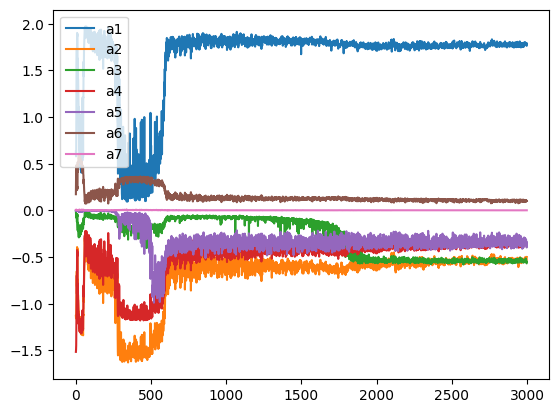

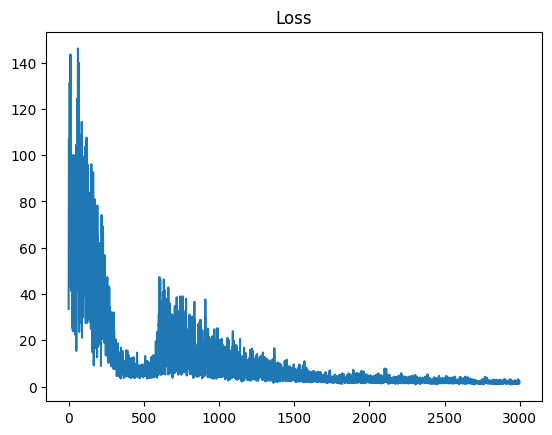

In [3]:
# Train
train_maml(num_epochs=3000)
torch.save(model.state_dict(), "model_1.pth")

In [4]:
print(a_star)

[0. 0. 0. 0. 0. 0. 0.]


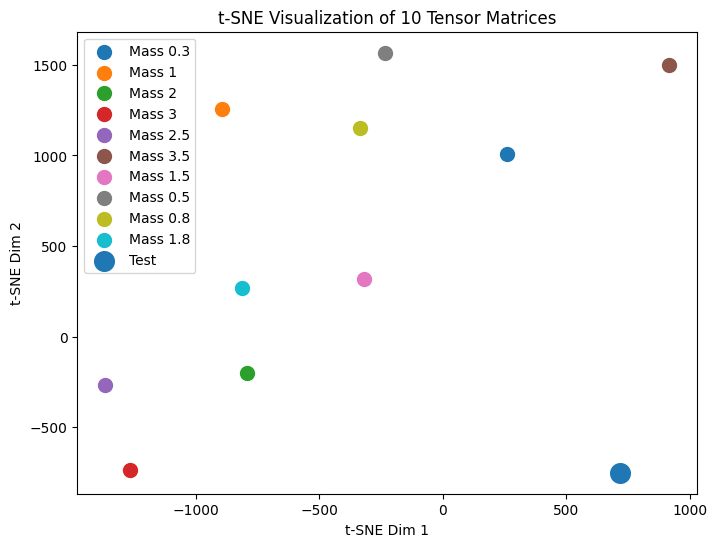

In [17]:
from sklearn.manifold import TSNE
# flattened_tensors = [t.view(-1).detach().numpy() for t in a_list]
a_final = np.array([ 0.06401914, 0.15754268, -0.02821851, -0.14481887, 0.00698458, 0.9742982 , 0.00270006])
b_list.append(a_final)
flattened_tensors = [t.view(-1).detach().numpy() for t in torch.tensor(np.array(b_list), dtype=torch.float32)]

tSNE = np.array(flattened_tensors)

tsne = TSNE(n_components=2, perplexity=3)
X_embedded = tsne.fit_transform(tSNE)

plt.figure(figsize=(8, 6))

plt.scatter(X_embedded[0, 0], X_embedded[0, 1], label='Mass 0.3', s=100)
plt.scatter(X_embedded[1, 0], X_embedded[1, 1], label='Mass 1', s=100)
plt.scatter(X_embedded[2, 0], X_embedded[2, 1], label='Mass 2', s=100)
plt.scatter(X_embedded[3, 0], X_embedded[3, 1], label='Mass 3', s=100)
plt.scatter(X_embedded[4, 0], X_embedded[4, 1], label='Mass 2.5', s=100)
plt.scatter(X_embedded[5, 0], X_embedded[5, 1], label='Mass 3.5', s=100)
plt.scatter(X_embedded[6, 0], X_embedded[6, 1], label='Mass 1.5', s=100)
plt.scatter(X_embedded[7, 0], X_embedded[7, 1], label='Mass 0.5', s=100)
plt.scatter(X_embedded[8, 0], X_embedded[8, 1], label='Mass 0.8', s=100)
plt.scatter(X_embedded[9, 0], X_embedded[9, 1], label='Mass 1.8', s=100)
plt.scatter(X_embedded[10, 0], X_embedded[10, 1], label='Test', s=200)

plt.xlabel('t-SNE.png Dim 1')
plt.ylabel('t-SNE.png Dim 2')
# plt.xlim(-100, 100)
# plt.ylim(-150, 150)
plt.title('t-SNE.png Visualization of 10 Tensor Matrices')
plt.legend(loc='best')
plt.show()


[ 1.75  0.55 -0.65 -0.4   0.4   0.2   0.  ]


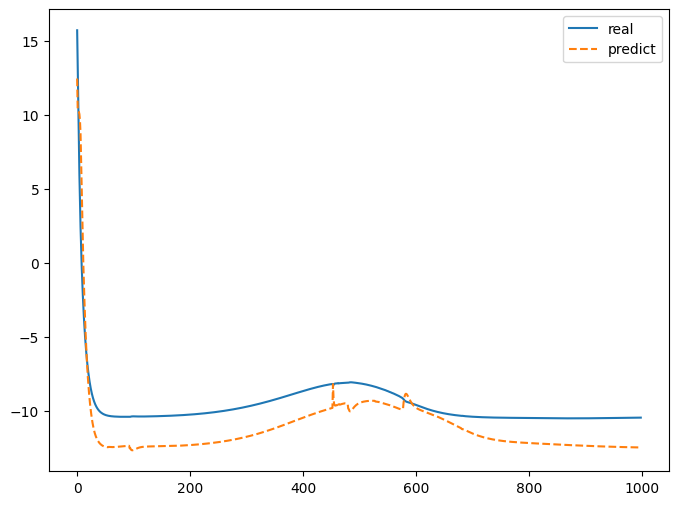

In [123]:
Test_X_1 = pd.read_csv('Test_x_1.csv')
Test_Y_1 = pd.read_csv('Test_y_1.csv')
X_test_update_1 = torch.tensor(np.array(Test_X_1), dtype=torch.float32)
Y_test_update_1 = torch.tensor(np.array(Test_Y_1), dtype=torch.float32)
a_star = np.array([ 1.75, 0.55, -0.65, -0.4, 0.4, 0.2, 0])
model1 = SimpleNN()
model1.load_state_dict(torch.load("model_1.pth", weights_only=True))

y_pred = model1(X_test_update_1)
print(a_star)
y_pred_original = y_pred * torch.tensor(np.array(a_star), dtype=torch.float32)
# y_pred_original = y_pred @ a_list[4]
y_test_original = Test_Y_1

# mse = mean_squared_error(y_test_original, y_pred_original)
# rmse = np.sqrt(mse)

plt.figure(figsize=(8, 6))
plt.plot(y_test_original.values[:,3], label='real', linestyle='-')
plt.plot(y_pred_original.detach()[:,3], label='predict', linestyle='--')
plt.legend()
plt.show()

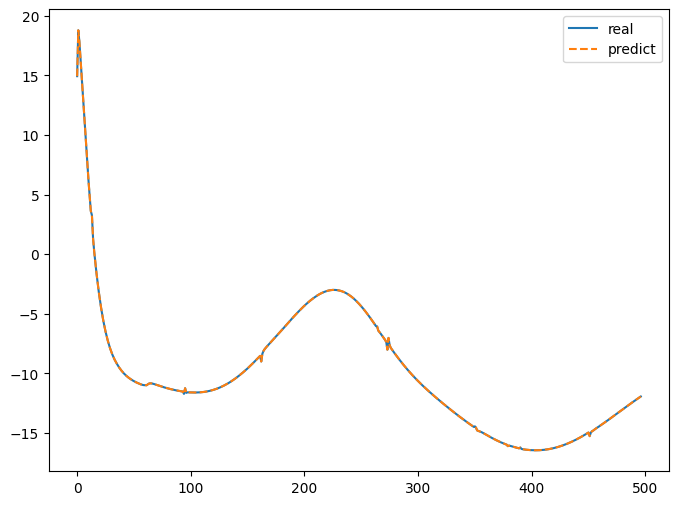

In [371]:
Test_X_1 = pd.read_csv('Test_x_2.csv')
Test_Y_1 = pd.read_csv('Test_y_2.csv')
X_test_update_1 = torch.tensor(np.array(Test_X_1), dtype=torch.float32)
Y_test_update_1 = torch.tensor(np.array(Test_Y_1), dtype=torch.float32)

y_nn = model(X_test_update_1) * torch.tensor(np.array(b_list[4]), dtype=torch.float32)
y_real = Test_Y_1
y_pred_adaptive = []
for i in range(len(Test_X_1)):
    error = np.array(Test_Y_1)[i] - y_pred.detach().numpy()[i]
    # print(np.ones(7) + error)
    y_pred_adaptive.append(y_pred.detach().numpy()[i] + 1 * error)

y_pred_adaptive = np.array(y_pred_adaptive)
plt.figure(figsize=(8, 6))
plt.plot(y_test_original.values[:,3], label='real', linestyle='-')
plt.plot(y_pred_adaptive[:,3], label='predict', linestyle='--')
plt.legend()
plt.show()

Step 1, Loss:19.451847076416016
Step 2, Loss:17.60045051574707
Step 3, Loss:16.856155395507812
Step 4, Loss:16.617900848388672
Step 5, Loss:17.651691436767578
Step 6, Loss:22.49568748474121
Step 7, Loss:17.67475128173828
Step 8, Loss:17.396717071533203
Step 9, Loss:17.177143096923828
Step 10, Loss:17.037534713745117
Step 11, Loss:16.710115432739258
Step 12, Loss:16.578935623168945
Step 13, Loss:17.30619239807129
Step 14, Loss:17.106027603149414
Step 15, Loss:16.385488510131836
Step 16, Loss:16.156084060668945
Step 17, Loss:15.99816608428955
Step 18, Loss:15.846116065979004
Step 19, Loss:15.703437805175781
Step 20, Loss:15.496417999267578
Step 21, Loss:15.295186996459961
Step 22, Loss:15.396552085876465
Step 23, Loss:14.923095703125
Step 24, Loss:14.462172508239746
Step 25, Loss:14.534857749938965
Step 26, Loss:14.177774429321289
Step 27, Loss:14.122920989990234
Step 28, Loss:14.064842224121094
Step 29, Loss:15.952730178833008
Step 30, Loss:14.888073921203613
Step 31, Loss:14.2496347427

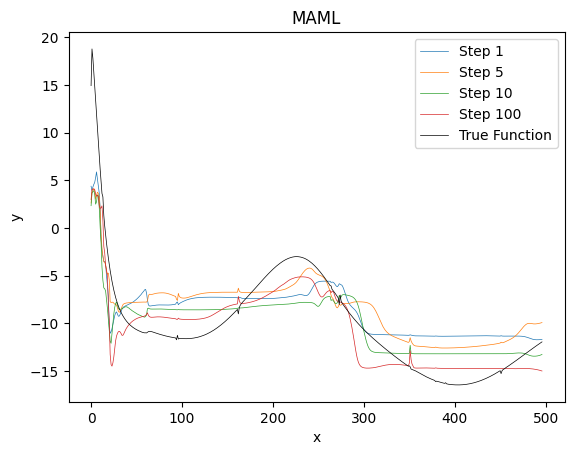

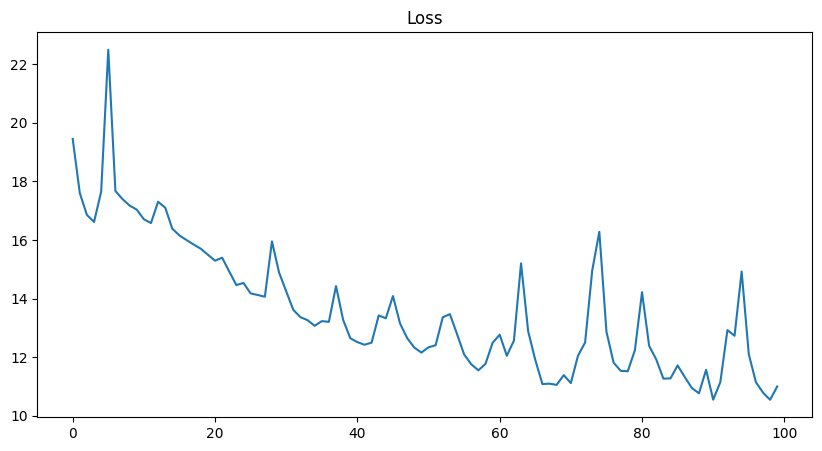

In [115]:
# MAML update
predictions = []
loss_print = []
# fast_weights = {name: param.clone() for name, param in model.named_parameters()}
# for step in range(10):
#     update_point_x = np.array(Test_X_1)
#     update_point_y = np.array(Test_Y_1)
#     update_point_x = torch.tensor(np.array(update_point_x), dtype=torch.float32)
#     update_point_y = torch.tensor(np.array(update_point_y), dtype=torch.float32)
#     pred_y = model(update_point_x, params=fast_weights)
#     loss = loss_fn(pred_y, update_point_y)
#
#     gradients = torch.autograd.grad(loss, fast_weights.values(), create_graph=True)
#
#     for (name, param), grad in zip(fast_weights.items(), gradients):
#         fast_weights[name] = param - 0.002 * grad
#
#     maml_pred = model(torch.tensor(np.array(Test_X_1), dtype=torch.float32), params=fast_weights)
#     predictions.append(maml_pred)
#
#     print(f"Step {step+1}, Loss:{loss_fn(maml_pred, update_point_y)}")
#
#     rmse = loss_fn(maml_pred, update_point_y)
#     loss_print.append(rmse.detach())
updated_model = SimpleNN()
updated_model.load_state_dict(model.state_dict())
for step in range(100):
    update_point_x = np.array(Test_X_1)
    update_point_y = np.array(Test_Y_1)
    update_point_x = torch.tensor(np.array(update_point_x), dtype=torch.float32)
    update_point_y = torch.tensor(np.array(update_point_y), dtype=torch.float32)
    pred_y = updated_model(update_point_x)
    loss = loss_fn(pred_y, update_point_y)

    grads = torch.autograd.grad(loss, updated_model.parameters(), create_graph=True)

    with torch.no_grad():
        for param, grad in zip(updated_model.parameters(), grads):
            param.copy_(param - 0.005 * grad)  # θ' = θ - α * ∇L

    maml_pred = updated_model(update_point_x)
    predictions.append(maml_pred)

    print(f"Step {step+1}, Loss:{loss_fn(maml_pred, update_point_y)}")

    rmse = loss_fn(maml_pred, update_point_y)
    loss_print.append(rmse.detach())

# Plot result
for i, pred in enumerate(predictions):
    if i in (0,4,9,99):
        plt.plot(pred.detach().numpy()[:,3], label=f"Step {i+1}", linewidth=0.5)

plt.plot(Y_test_update_1.detach().numpy()[:,3], label="True Function", color="black", linewidth=0.5)
plt.legend()
plt.title("MAML")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(loss_print)
plt.title("Loss")
plt.show()